# Distribution-Aware Replay for Continual MRI Segmentation - Figures
In this section we will generate the visualizations used in our paper.

## Figure 4
To generate Fig. 4 from our paper, you need to run the following script. This script contains hard coded paths for the evaluation output folder of each method. Make sure to set them according to your evaluation setup.

In [ ]:
!python plot_hippocampus_with_ood.py
!python plot_prostate_with_ood.py

Executing this script should generate an image called `plot_hippocampus_with_ood.png`.

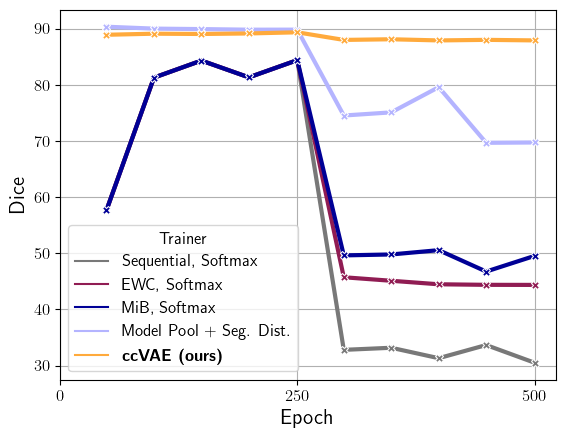

In [9]:
from IPython.display import Image
Image(filename=('plot_hippocampus_with_ood.png'))

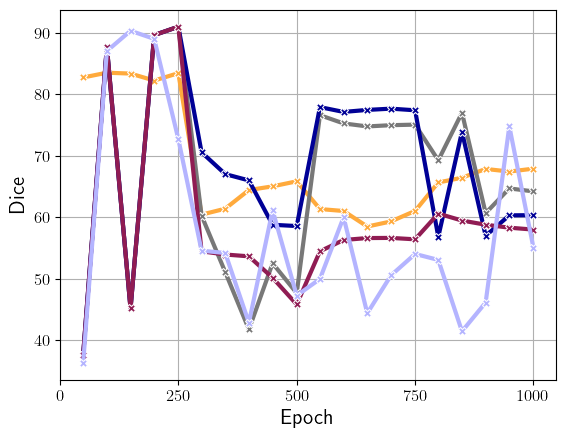

In [10]:
from IPython.display import Image
Image(filename=('plot_prostate_with_ood.png'))

## Figure 6
To generate this figure, we first need to generate features from a trained VAE. Here you need to set a bunch of variables that specify the specific VAE checkpoint to be loaded. Take a look at [continue_training.py](continue_training.py) to get a feel of how to set these variables.

In [ ]:
from nnunet_ext.network_architecture.generic_UNet_no_skips import Generic_UNet_no_skips
from nnunet_ext.training.model_restore import restore_model
import os, torch
from nnunet_ext.training.network_training.vae_rehearsal_no_skips.nnUNetTrainerVAERehearsalNoSkips import nnUNetTrainerVAERehearsalNoSkips

all_tasks = ["Task197_DecathHip", "Task198_Dryad", "Task199_HarP"]
extension_type = "vae_rehearsal_no_skips_large"
trainer_class_name = "nnUNetTrainerVAERehearsalNoSkipsLarge"
unet_trained_on = ["Task197_DecathHip", "Task198_Dryad"]
vae_trained_on = ["Task197_DecathHip", "Task198_Dryad"]
os.environ["CUDA_VISIBLE_DEVICES"] = ""
results_folder = os.environ['RESULTS_FOLDER']   #alternatively, specify the path here

trainer_path = f"{results_folder}/nnUNet_ext/2d/{'_'.join(all_tasks)}/{'_'.join(unet_trained_on)}/{trainer_class_name}__nnUNetPlansv2.1/Generic_UNet/SEQ/fold_0"
checkpoint = os.path.join(trainer_path, "model_final_checkpoint.model")
pkl_file = checkpoint + ".pkl"

trainer: nnUNetTrainerVAERehearsalNoSkips = restore_model(pkl_file, checkpoint, train=True, fp16=True,\
                        use_extension=True, extension_type=extension_type, del_log=True,\
                        param_search=False, network="2d")

trainer.network.__class__ = Generic_UNet_no_skips
trainer.freeze_network()
vae_dict = torch.load(f"{results_folder}/nnUNet_ext/2d/{'_'.join(all_tasks)}/{'_'.join(vae_trained_on)}/{trainer_class_name}__nnUNetPlansv2.1/Generic_UNet/SEQ/fold_0/vae.model")
trainer.initialize_vae(trainer.get_anatomy(vae_dict['shape']), vae_dict['shape'], vae_dict['num_classes'], conditional_dim=vae_dict['conditional_dim'])
trainer.vae.load_state_dict(vae_dict['state_dict'])


trainer.clean_up()
trainer.load_dataset()
trainer.do_split()
trainer.store_features(unet_trained_on[0])
trainer.store_features(unet_trained_on[0], False)
trainer.update_dataloader(unet_trained_on[0])


trainer.generate_features()

Now you need to set the variables in the [inspect_segmentation.py](inspect_segmentation.py) script to the ones you have used in the cell above. Also set `task_to_be_visualized` to the task whose segmentations you want to see. Now you can generate the figure using the following command:

In [ ]:
!python inspect_segmentation.py

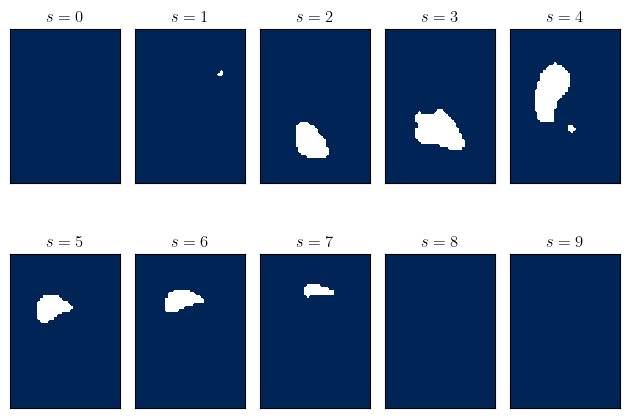

In [11]:
from IPython.display import Image
Image(filename=('generated_features.png'))

After generating the figure do not forget to delete the generated features to free up disk space.

In [ ]:
trainer.clean_up()